# Analytical differentiation. Practical exercise with SymPy.

In this exercise, we will optimize to find the parameters of a model that fit a given set of data. We will use the gradient descent method, computing analytically the derivatives of the proposed loss.

#### The data
We have collected experimental data that measure the perceived clarity of an image on a scale from 0 to 1 as a function of the image's illumination level (0 represents complete blurriness, and 1 means full clarity)

Herein, we import and plot the experimental data:

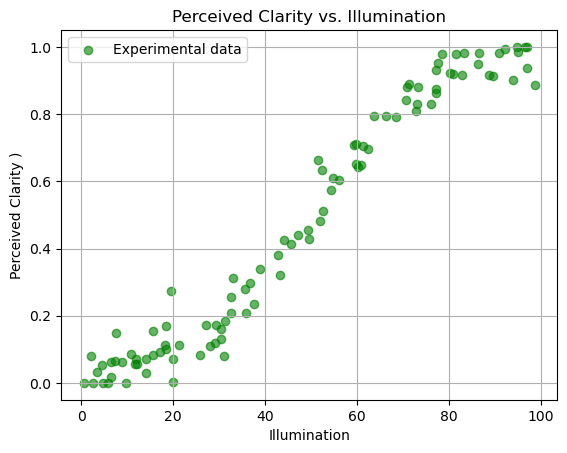

In [1]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from CSV file
data = pd.read_csv('data/clarity_noisy_data.csv')

# Extract columns of the data file
x_data = data['Illumination'].values  # Features
y_true_data = data['Clarity'].values  # Targets

#plot the experimental data
def plot_data(x_data, y_true_data):
    plt.scatter(x_data, y_true_data, color="green", label="Experimental data", alpha=0.6)
    # Labels and plot formatting
    plt.xlabel("Illumination")
    plt.ylabel("Perceived Clarity )")
    plt.title("Perceived Clarity vs. Illumination")
    plt.legend()
    plt.grid(True)
    
plot_data(x_data, y_true_data)

#### The logistic model
the perceived clarity predicted by the logistic model, denoted as $y_{pred}$, is obtained for a level of illumination $x$
\begin{equation*}
y_{pred} = \sigma (wx +b), \qquad \sigma(z) =\frac{1}{1+e^{-z}},
\end{equation*}
where $y_{pred}$ is the perceived clarity predicted by the model for a level of illumination $x$ and the set $\theta = \{w,b\}$ group the parameters of the model that we have to adjust.

In [2]:
import sympy as sp

#variable and parameters declaration
x = sp.symbols('x')
w,b = sp.symbols('w b')

z = w*x + b #afine transformation
y_pred = 1 / (1 + sp.exp(-z)) #logistic function


y_t = sp.Symbol('y_t',constant = True)
loss = (y_t - y_pred)**2

#### The loss function
For simplicity, we have chosen the Mean Square Error (MSE)
\begin{equation*}
\mathcal{L}:= \dfrac{1}{N} \sum_{j=1}^N(y_{true,j}- y_{pred,j})^2,
\end{equation*}
where $j \in \{1, 2, \dots, N\}$ denote one of the $N$ data.

a) We definie symbollycally the loss for a single data.

In [3]:
y_t = sp.Symbol('y_t',constant = True)
loss = (y_t - y_pred)**2.

b) To evaluate numerically we need to convert into a numeric function

In [4]:
# We convert the symbolic function into a numeric NumPy function
loss_numeric = sp.lambdify((x, y_t, w, b), loss, 'numpy')

#### Numerical method
We choose the gradient descent for the minimization. The update of the parameters $\theta$ is done by the expression:
\begin{equation*}
\theta_{i+1} := \theta_i - \alpha \frac{\partial \mathcal{L}}{\partial \theta}
\end{equation*}
where $\theta$ are the parameters to optimize and $\alpha$ denotes the learning rate.

In matricial form, we have:
\begin{equation*}
  \begin{pmatrix}
   w_{i+1} \\
   b_{i+1}
  \end{pmatrix}
=
  \begin{pmatrix}
   w_i \\
   b_i
  \end{pmatrix}
- \alpha
  \begin{pmatrix}
   \dfrac{\partial{\mathcal{L}}}{\partial w} \\
   \dfrac{\partial{\mathcal{L}}}{\partial b}
  \end{pmatrix} 
\end{equation*}

In [5]:
def GD(theta, dL, lr):
    theta_updated = theta - lr*dL
    return theta_updated

#### Procedure
  1. Compute the derivatives analytically.
  2. Evaluate the derivatives over all the samples and do the sum.
  3. Define the training.
  4. Choose the training hyperparameters and run the optimization.
  5. Plot the model within the experimental data.

##### Step 1: Compute the derivatives analytically.

We compute analytically the derivative $\dfrac{\partial{\mathcal{L_j}}}{\partial w}$ only for one element of the sum.

\begin{equation}
\dfrac{\partial{\mathcal{L}}}{\partial w} = \sum_{j=1}^N \dfrac{\partial{\mathcal{L_j}}}{\partial w}.
\end{equation}

In [6]:
dLj_dw = sp.diff(loss, w)
dLj_dw #to display the derivative

-2.0*x*(y_t - 1/(exp(-b - w*x) + 1))**1.0*exp(-b - w*x)/(exp(-b - w*x) + 1)**2

In [7]:
# We convert the symbolic function into a numeric NumPy function
dL_dw_numeric = sp.lambdify((x, y_t, w, b), dLj_dw, 'numpy')

Simarly we compute the deivative $\dfrac{\partial{\mathcal{L_j}}}{\partial b}$.

In [8]:
dLj_db = sp.diff(loss, b)
dLj_db  #to display the derivative

-2.0*(y_t - 1/(exp(-b - w*x) + 1))**1.0*exp(-b - w*x)/(exp(-b - w*x) + 1)**2

In [9]:
# We convert the symbolic function into a numeric NumPy function
dL_db_numeric = sp.lambdify((x, y_t, w, b), dLj_db, 'numpy')

##### Step 2: Define the training.

In [10]:
def training (x_data, y_true_data, n_epochs, lr, w_0, b_0, tol= 1E-3):
    #we initialize the parameters
    w_val = w_0
    b_val = b_0

    #number of data
    N = x_data.shape[0]
    
    #evaluate the initial loss
    loss_val = np.sum(loss_numeric(x_data, y_true_data, w_val ,b_val))/N
    print(f"Initial loss: {loss_val}")
    
    history =[loss_val]
    
    #training loop
    for epoch in range(n_epochs):
        #evaluate the stop criteria
        if loss_val < tol:
                print(f"Stop criterion reached. Loos is smaller than {tol}.")
                break
        #compute the gradients.
        dL_dtheta = np.array([np.sum(dL_dw_numeric(x_data, y_true_data, w_val, b_val)), 
                              np.sum(dL_db_numeric(x_data, y_true_data, w_val, b_val))])/N
        #apply gradient descent
        new_theta = GD(np.array([w_val,b_val]), dL_dtheta, lr)
        # unpackage
        w_val, b_val = new_theta
        
        #evaluate the loss
        loss_val = np.sum(loss_numeric(x_data, y_true_data, w_val, b_val))/N
        
        history.append(loss_val)
        #uncoment to print the loss each n iterations
        #if epoch%10000 == 0:
        #    print(f"Iteration {epoch}: loss = {loss_val}")
   
    print(f"Iteration {epoch}: loss = {loss_val}")
    print(f"Final parameters w = {w_val}; b = {b_val}")
    
    history_loss = np.array(history)

    #We plot the loss history
    def plot_loss(history_loss):
        x = np.arange(history_loss.shape[0])
        plt.plot(x, history_loss, color="black")
        # Labels and plot formatting
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss evolution")
        plt.grid(True)
        # Set y-axis to logarithmic scale
        plt.yscale('log')
        # Show the plot
        plt.show()
    plot_loss(history_loss)
    
    return w_val, b_val

##### Step 3: Define training parameters and run the optimization.

Initial loss: 0.39288341069734484
Iteration 49999: loss = 0.0024178063264907817
Final parameters w = 0.07306998537061755; b = -3.613595596255927


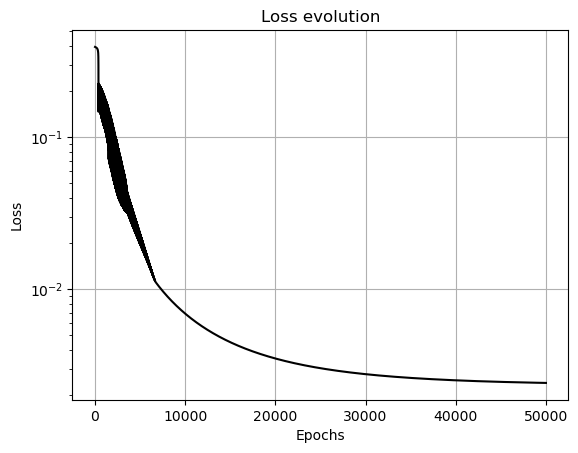

In [11]:
w0 = 0.5
b0 = 0.5
number_epochs = 50000
lr = 0.01

w_val, b_val = training (x_data, y_true_data, number_epochs, lr, w0, b0)

##### Step 4: Plot results.

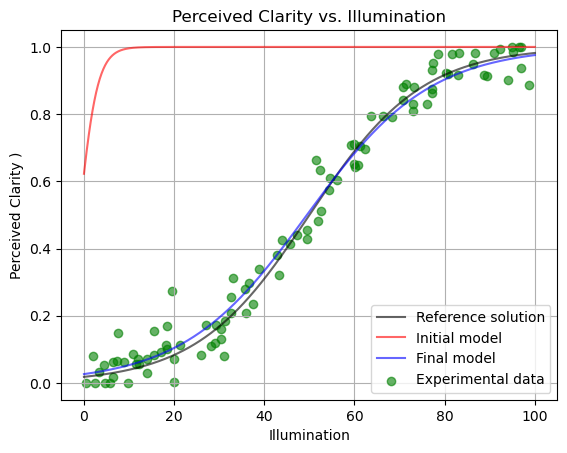

In [12]:
y_pred_numeric = sp.lambdify((x, w, b), y_pred, 'numpy')
x_uniform = np.linspace(0,100,1000)

y_reference = y_pred_numeric(x_uniform, 0.08, -4)
y_predicted_final = y_pred_numeric(x_uniform, w_val, b_val)
y_predicted_initial = y_pred_numeric(x_uniform, w0, b0)
#plot the experimental data
plt.plot(x_uniform, y_reference, color="black", label="Reference solution", alpha=0.6)
plt.plot(x_uniform, y_predicted_initial, color="red", label="Initial model", alpha=0.6)
plt.plot(x_uniform, y_predicted_final, color="blue", label="Final model", alpha=0.6)
plt.scatter(x_data, y_true_data, color="green", label="Experimental data", alpha=0.6)
# Labels and plot formatting
plt.xlabel("Illumination")
plt.ylabel("Perceived Clarity )")
plt.title("Perceived Clarity vs. Illumination")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Conclusions
